# 특강 02: Supabase를 활용한 음원 데이터베이스 구축

## 학습 목표
- 클라우드 데이터베이스를 활용한 음원 데이터 관리 시스템을 구축해보자
- Supabase 설정 및 연동 방법을 익혀보자
- 음원 정보 저장을 위한 테이블 설계를 이해해보자
- Spotify API와 데이터베이스를 연동하여 음원 특성을 수집하고 저장해보자
- 저장된 데이터를 조회하고 분석하는 방법을 익혀보자

## 1. 환경 설정 및 라이브러리 임포트

In [1]:
import os
import json
import base64
from datetime import datetime
from typing import Dict, List, Optional

import pandas as pd
import numpy as np
import requests
from supabase import create_client, Client
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 로딩 완료")

라이브러리 로딩 완료


## 2. 자격 증명 설정 (.env 파일)

In [2]:
def load_credentials():
    """.env 파일에서 자격 증명을 로드한다."""
    env_file = '.env'
    
    # .env 파일이 없으면 템플릿 생성
    if not os.path.exists(env_file):
        template_content = """# Spotify API 자격 증명
SPOTIFY_CLIENT_ID=your_client_id_here
SPOTIFY_CLIENT_SECRET=your_client_secret_here

# Supabase 설정
SUPABASE_URL=your_supabase_url_here
SUPABASE_KEY=your_supabase_anon_key_here
"""
        with open(env_file, 'w') as f:
            f.write(template_content)
        
        print(".env 파일이 생성되었습니다!")
        print("실제 값들을 입력하고 다시 실행해주세요")
        return None, None, None, None
    
    # .env 파일에서 읽기
    client_id = None
    client_secret = None
    supabase_url = None
    supabase_key = None
    
    with open(env_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith('#') and '=' in line:
                key, value = line.split('=', 1)
                if key == 'SPOTIFY_CLIENT_ID':
                    client_id = value
                elif key == 'SPOTIFY_CLIENT_SECRET':
                    client_secret = value
                elif key == 'SUPABASE_URL':
                    supabase_url = value
                elif key == 'SUPABASE_KEY':
                    supabase_key = value
    
    if (client_id == 'your_client_id_here' or 
        client_secret == 'your_client_secret_here' or
        supabase_url == 'your_supabase_url_here' or
        supabase_key == 'your_supabase_anon_key_here'):
        print("경고: .env 파일에 실제 값을 입력해주세요!")
        return None, None, None, None
    
    if client_id and client_secret and supabase_url and supabase_key:
        print("자격 증명 로드 완료")
        return client_id, client_secret, supabase_url, supabase_key
    else:
        print("오류: .env 파일에 자격 증명이 없습니다.")
        return None, None, None, None

# 자격 증명 로드
SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET, SUPABASE_URL, SUPABASE_KEY = load_credentials()

자격 증명 로드 완료


## 3. Supabase 연동 설정

In [3]:
# Supabase 클라이언트 초기화
def init_supabase() -> Client:
    """
    Supabase 클라이언트를 초기화하고 연결을 테스트한다.
    성공적으로 연결되면 클라이언트 객체를 반환하고, 실패하면 None을 반환한다.
    """
    if not SUPABASE_URL or not SUPABASE_KEY:
        print("오류: .env 파일에서 Supabase 자격 증명을 먼저 설정해주세요!")
        return None
        
    try:
        supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
        print("Supabase 연결 성공")
        return supabase
    except Exception as e:
        print(f"Supabase 연결 실패: {e}")
        return None

supabase = init_supabase()

Supabase 연결 성공


## 4. 데이터베이스 테이블 생성

### 4.1 테이블 설계

음원 정보를 효율적으로 저장하기 위한 테이블 구조를 설계해보자.
각 컬럼은 Spotify API에서 제공하는 음원 특성과 매핑되며, 추가로 메타데이터를 포함한다.
아래 SQL은 Supabase SQL Editor에서 직접 실행할 수 있다.

In [4]:
# 테이블 생성 SQL (Supabase SQL Editor에서 실행)
create_table_sql = """
-- 음원 정보 테이블
CREATE TABLE IF NOT EXISTS tracks (
    id UUID DEFAULT gen_random_uuid() PRIMARY KEY,
    spotify_id VARCHAR(50) UNIQUE NOT NULL,
    name VARCHAR(255) NOT NULL,
    artist VARCHAR(255) NOT NULL,
    album VARCHAR(255),
    release_date DATE,
    duration_ms INTEGER,
    popularity INTEGER,
    preview_url TEXT,
    
    -- Audio Features
    danceability FLOAT,
    energy FLOAT,
    key INTEGER,
    loudness FLOAT,
    mode INTEGER,
    speechiness FLOAT,
    acousticness FLOAT,
    instrumentalness FLOAT,
    liveness FLOAT,
    valence FLOAT,
    tempo FLOAT,
    time_signature INTEGER,
    
    -- 메타데이터
    created_at TIMESTAMP WITH TIME ZONE DEFAULT NOW(),
    updated_at TIMESTAMP WITH TIME ZONE DEFAULT NOW(),
    source_type VARCHAR(50) DEFAULT 'manual'
);

-- 인덱스 생성
CREATE INDEX idx_tracks_artist ON tracks(artist);
CREATE INDEX idx_tracks_created_at ON tracks(created_at);
CREATE INDEX idx_tracks_popularity ON tracks(popularity);

-- RLS (Row Level Security) 활성화
ALTER TABLE tracks ENABLE ROW LEVEL SECURITY;

-- 모든 사용자가 읽을 수 있도록 정책 생성
CREATE POLICY "Enable read access for all users" ON tracks
    FOR SELECT USING (true);

-- 인증된 사용자만 삽입할 수 있도록 정책 생성
CREATE POLICY "Enable insert for authenticated users only" ON tracks
    FOR INSERT WITH CHECK (true);
"""

print("위 SQL을 Supabase SQL Editor에서 실행해주세요.")
print("경로: Supabase Dashboard → SQL Editor → New Query")

위 SQL을 Supabase SQL Editor에서 실행해주세요.
경로: Supabase Dashboard → SQL Editor → New Query


## 5. Spotify API 인증 및 헬퍼 함수

In [5]:
class SpotifyAPI:
    """Spotify API 클라이언트"""
    
    def __init__(self, client_id: str, client_secret: str):
        self.client_id = client_id
        self.client_secret = client_secret
        self.access_token = None
        self.token_expires = 0
    
    def get_access_token(self) -> str:
        """Client Credentials Flow로 액세스 토큰 획득"""
        if self.access_token and datetime.now().timestamp() < self.token_expires:
            return self.access_token
        
        auth_str = f"{self.client_id}:{self.client_secret}"
        auth_bytes = auth_str.encode('utf-8')
        auth_base64 = base64.b64encode(auth_bytes).decode('utf-8')
        
        headers = {
            'Authorization': f'Basic {auth_base64}',
            'Content-Type': 'application/x-www-form-urlencoded'
        }
        
        data = {'grant_type': 'client_credentials'}
        
        response = requests.post(
            'https://accounts.spotify.com/api/token',
            headers=headers,
            data=data
        )
        
        if response.status_code == 200:
            token_data = response.json()
            self.access_token = token_data['access_token']
            self.token_expires = datetime.now().timestamp() + token_data['expires_in']
            print("Spotify 인증 성공")
            return self.access_token
        else:
            print(f"Spotify 인증 실패: {response.status_code}")
            return None
    
    def get_track(self, track_id: str) -> Dict:
        """트랙 정보 가져오기"""
        token = self.get_access_token()
        if not token:
            return None
        
        headers = {'Authorization': f'Bearer {token}'}
        url = f'https://api.spotify.com/v1/tracks/{track_id}'
        
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"트랙 정보 조회 실패: {response.status_code}")
            return None
    
    def search_track(self, query: str, limit: int = 10) -> List[Dict]:
        """트랙 검색"""
        token = self.get_access_token()
        if not token:
            return []
        
        headers = {'Authorization': f'Bearer {token}'}
        params = {
            'q': query,
            'type': 'track',
            'limit': limit
        }
        
        response = requests.get(
            'https://api.spotify.com/v1/search',
            headers=headers,
            params=params
        )
        
        if response.status_code == 200:
            return response.json()['tracks']['items']
        else:
            print(f"검색 실패: {response.status_code}")
            return []


class ReccoBeatsAPI:
    """
    ReccoBeats API 클라이언트 - Spotify Audio Features API 대체
    
    2024년 11월 27일부터 Spotify는 Audio Features API 접근을 제한했습니다.
    ReccoBeats API를 통해 음원 특성을 분석할 수 있습니다.
    """
    
    def __init__(self):
        self.base_url = "https://api.reccobeats.com/v1"
    
    def get_content_id_by_spotify_id(self, spotify_track_id: str) -> Optional[str]:
        """Spotify 트랙 ID로 ReccoBeats content ID 조회"""
        try:
            url = f"{self.base_url}/track"
            params = {"ids": spotify_track_id}
            
            response = requests.get(url, params=params, timeout=30)
            
            if response.status_code == 200:
                data = response.json()
                if isinstance(data, dict) and 'content' in data and len(data['content']) > 0:
                    return data['content'][0].get('id')
            return None
            
        except Exception as e:
            print(f"ReccoBeats content ID 조회 실패: {e}")
            return None
    
    def get_audio_features(self, spotify_track_id: str) -> Optional[Dict]:
        """Spotify ID로 음원 특성 가져오기 (2단계 프로세스)"""
        # 1단계: ReccoBeats content ID 조회
        content_id = self.get_content_id_by_spotify_id(spotify_track_id)
        if not content_id:
            print(f"ReccoBeats에서 트랙을 찾을 수 없음: {spotify_track_id}")
            return None
        
        # 2단계: 음원 특성 조회
        try:
            url = f"{self.base_url}/track/{content_id}/audio-features"
            response = requests.get(url, timeout=30)
            
            if response.status_code == 200:
                return response.json()
            else:
                print(f"음원 특성 조회 실패: {response.status_code}")
                return None
                
        except Exception as e:
            print(f"음원 특성 API 호출 실패: {e}")
            return None

In [6]:
# Spotify API 및 ReccoBeats API 클라이언트 초기화
if SPOTIFY_CLIENT_ID and SPOTIFY_CLIENT_SECRET:
    spotify = SpotifyAPI(SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET)
    reccobeats = ReccoBeatsAPI()
    
    # 테스트: 액세스 토큰 획득
    token = spotify.get_access_token()
    if token:
        print(f"Spotify 액세스 토큰: {token[:20]}...")
        print("ReccoBeats API 클라이언트도 준비 완료")
else:
    print("먼저 .env 파일에 Spotify 자격 증명을 입력해주세요!")
    spotify = None
    reccobeats = None

Spotify 인증 성공
Spotify 액세스 토큰: BQDb6INbnSH9YC6LoknN...
ReccoBeats API 클라이언트도 준비 완료


## 6. 데이터 적재 함수 구현

### 6.1 TrackDatabase 클래스

데이터베이스와 Spotify API를 연동하여 음원 정보를 관리하는 클래스를 구현해보자.
이 클래스는 음원 정보의 저장, 조회, 분석 기능을 제공한다.
객체 지향 프로그래밍을 통해 코드의 재사용성과 유지보수성을 높일 수 있다.

In [7]:
class TrackDatabase:
    """트랙 데이터베이스 관리 클래스"""
    
    def __init__(self, supabase_client: Client, spotify_client: SpotifyAPI, reccobeats_client: ReccoBeatsAPI):
        self.supabase = supabase_client
        self.spotify = spotify_client
        self.reccobeats = reccobeats_client
    
    def check_existing_tracks(self, spotify_ids: List[str]) -> List[str]:
        """여러 Spotify ID의 존재 여부를 한 번에 확인"""
        try:
            response = self.supabase.table('tracks').select('spotify_id').in_('spotify_id', spotify_ids).execute()
            existing_ids = [track['spotify_id'] for track in response.data]
            return existing_ids
        except Exception as e:
            print(f"중복 체크 실패: {e}")
            return []
    
    def check_duplicate_by_name_and_tempo(self, name: str, tempo: float) -> bool:
        """이름과 템포가 모두 같은 트랙이 있는지 확인"""
        try:
            if tempo is not None:
                # 템포가 있는 경우: 이름과 템포 모두 확인
                response = self.supabase.table('tracks').select('spotify_id, name, tempo').eq('name', name).eq('tempo', tempo).execute()
                if response.data:
                    return True
            else:
                # 템포가 없는 경우: 이름만 확인하되 템포도 None인 경우만
                response = self.supabase.table('tracks').select('spotify_id, name, tempo').eq('name', name).is_('tempo', 'null').execute()
                if response.data:
                    return True
            
            return False
        except Exception as e:
            print(f"이름/템포 중복 체크 실패: {e}")
            return False
    
    def save_track_by_id(self, track_id: str, source_type: str = 'manual', skip_without_features: bool = True) -> bool:
        """Spotify ID로 트랙 정보를 가져와서 저장"""
        
        # 1. Spotify ID로 중복 확인
        existing = self.supabase.table('tracks').select('spotify_id').eq('spotify_id', track_id).execute()
        if existing.data:
            print(f"이미 저장된 트랙입니다: {track_id}")
            track_info = self.spotify.get_track(track_id)
            if track_info:
                print(f"   → {track_info['name']} - {', '.join([a['name'] for a in track_info['artists']])}")
            return False
        
        # 트랙 정보 가져오기
        track_info = self.spotify.get_track(track_id)
        if not track_info:
            print(f"트랙 정보를 가져올 수 없습니다: {track_id}")
            return False
        
        # ReccoBeats API로 오디오 특성 가져오기
        audio_features = self.reccobeats.get_audio_features(track_id)
        
        # 오디오 특성이 없고 skip_without_features가 True면 저장하지 않음
        if not audio_features and skip_without_features:
            print(f"오디오 특성이 없어 건너뜁니다: {track_info['name']} - {', '.join([a['name'] for a in track_info['artists']])}")
            return False
        
        if not audio_features:
            print(f"오디오 특성을 가져올 수 없습니다 (ReccoBeats에 없는 트랙): {track_id}")
            audio_features = {}
        
        # 2. 이름과 템포로 중복 체크
        track_name = track_info['name']
        track_tempo = audio_features.get('tempo') if audio_features else None
        
        if self.check_duplicate_by_name_and_tempo(track_name, track_tempo):
            print(f"이름과 템포가 같은 트랙이 이미 존재합니다!")
            print(f"   트랙: {track_name}")
            print(f"   아티스트: {', '.join([a['name'] for a in track_info['artists']])}")
            if track_tempo:
                print(f"   템포: {track_tempo:.1f} BPM")
            print(f"   → 중복으로 판단하여 저장을 건너뜁니다.")
            return False
        
        # 데이터 준비
        track_data = {
            'spotify_id': track_id,
            'name': track_info['name'],
            'artist': ', '.join([artist['name'] for artist in track_info['artists']]),
            'album': track_info['album']['name'],
            'release_date': track_info['album']['release_date'],
            'duration_ms': track_info['duration_ms'],
            'popularity': track_info['popularity'],
            'preview_url': track_info.get('preview_url'),
            
            # Audio Features (ReccoBeats에서 가져온 데이터)
            'danceability': audio_features.get('danceability'),
            'energy': audio_features.get('energy'),
            'key': audio_features.get('key'),
            'loudness': audio_features.get('loudness'),
            'mode': audio_features.get('mode'),
            'speechiness': audio_features.get('speechiness'),
            'acousticness': audio_features.get('acousticness'),
            'instrumentalness': audio_features.get('instrumentalness'),
            'liveness': audio_features.get('liveness'),
            'valence': audio_features.get('valence'),
            'tempo': audio_features.get('tempo'),
            'time_signature': audio_features.get('time_signature'),
            
            'source_type': source_type
        }
        
        # 데이터베이스에 저장
        try:
            result = self.supabase.table('tracks').insert(track_data).execute()
            print(f"저장 완료: {track_info['name']} - {track_data['artist']}")
            return True
        except Exception as e:
            # UNIQUE 제약 조건 위반 시 처리
            if 'duplicate key' in str(e).lower() or 'unique' in str(e).lower():
                print(f"이미 저장된 트랙입니다: {track_info['name']} - {track_data['artist']}")
                return False
            else:
                print(f"저장 실패: {e}")
                return False
    
    def save_tracks_by_search(self, query: str, limit: int = 5, skip_without_features: bool = True) -> int:
        """검색 결과로 여러 트랙 저장"""
        tracks = self.spotify.search_track(query, limit)
        if not tracks:
            print(f"검색 결과가 없습니다: {query}")
            return 0
        
        # 모든 트랙 ID 추출
        track_ids = [track['id'] for track in tracks]
        
        # 한 번에 중복 체크
        existing_ids = self.check_existing_tracks(track_ids)
        new_tracks = [track for track in tracks if track['id'] not in existing_ids]
        
        if existing_ids:
            print(f"{len(existing_ids)}개 트랙이 이미 저장되어 있습니다")
        
        saved_count = 0
        skipped_count = len(existing_ids)
        
        # 새로운 트랙만 저장
        for track in new_tracks:
            track_id = track['id']
            result = self.save_track_by_id(track_id, source_type='search', skip_without_features=skip_without_features)
            if result:
                saved_count += 1
        
        print(f"\n결과: 저장 {saved_count}개 / 중복 {skipped_count}개 / 전체 {len(tracks)}개")
        return saved_count
    
    def get_all_tracks(self) -> pd.DataFrame:
        """모든 트랙 조회"""
        response = self.supabase.table('tracks').select('*').order('created_at', desc=True).execute()
        if response.data:
            return pd.DataFrame(response.data)
        return pd.DataFrame()
    
    def get_tracks_by_artist(self, artist: str) -> pd.DataFrame:
        """아티스트별 트랙 조회"""
        response = self.supabase.table('tracks').select('*').ilike('artist', f'%{artist}%').execute()
        if response.data:
            return pd.DataFrame(response.data)
        return pd.DataFrame()
    
    def get_track_stats(self) -> Dict:
        """트랙 통계 정보"""
        df = self.get_all_tracks()
        if df.empty:
            return {}
        
        # NULL 값 제외하고 통계 계산
        stats = {
            'total_tracks': len(df),
            'tracks_with_features': df['energy'].notna().sum() if 'energy' in df else 0,
            'unique_artists': df['artist'].nunique(),
            'avg_popularity': df['popularity'].mean() if 'popularity' in df else 0,
        }
        
        # 오디오 특성 통계 (NULL이 아닌 값들만)
        audio_features = ['energy', 'valence', 'tempo', 'danceability']
        for feature in audio_features:
            if feature in df and df[feature].notna().any():
                stats[f'avg_{feature}'] = df[feature].dropna().mean()
            else:
                stats[f'avg_{feature}'] = None
        
        # 가장 인기있는 트랙
        if 'popularity' in df and not df.empty:
            most_popular = df.nlargest(1, 'popularity')[['name', 'artist', 'popularity']].to_dict('records')
            if most_popular:
                stats['most_popular_track'] = most_popular[0]
        
        return stats

In [8]:
# TrackDatabase 초기화
if supabase and spotify and reccobeats:
    track_db = TrackDatabase(supabase, spotify, reccobeats)
    print("TrackDatabase 초기화 완료")
    print("- Spotify API: 트랙 정보 검색")
    print("- ReccoBeats API: 오디오 특성 분석") 
    print("- Supabase: 데이터 저장 및 관리")
else:
    print("필요한 클라이언트가 초기화되지 않았습니다.")
    track_db = None

TrackDatabase 초기화 완료
- Spotify API: 트랙 정보 검색
- ReccoBeats API: 오디오 특성 분석
- Supabase: 데이터 저장 및 관리


## 7. 데이터 적재 실습

In [ ]:
# 예제 1: 특정 Spotify ID로 트랙 저장
if track_db:
    sample_track_ids = [
        '3n3Ppam7vgaVa1iaRUc9Lp',  # Mr. Brightside - The Killers
        '4cOdK2wGLETKBW3PvgPWqT',  # Pumped Up Kicks
        '0VjIjW4GlUZAMYd2vXMi3b',  # Blinding Lights - The Weeknd
    ]

    for track_id in sample_track_ids:
        track_db.save_track_by_id(track_id)
        print("-" * 50)
else:
    print("TrackDatabase가 초기화되지 않았습니다.")

In [ ]:
# 예제 2: 검색으로 트랙 저장
if track_db:
    search_queries = [
        "dok2",
        "Paloalto",
        "LOCO",
        "gray",
        "에스파",
    ]

    for query in search_queries:
        print(f"\n검색: {query}")
        track_db.save_tracks_by_search(query, limit=15)
        print("=" * 50)
else:
    print("TrackDatabase가 초기화되지 않았습니다.")

## 8. 데이터 조회 및 분석

In [9]:
# 모든 트랙 조회
if track_db:
    df_tracks = track_db.get_all_tracks()
    print(f"총 {len(df_tracks)}개 트랙이 저장되어 있습니다")
    df_tracks.head()
else:
    print("TrackDatabase가 초기화되지 않았습니다.")
    df_tracks = pd.DataFrame()

총 1000개 트랙이 저장되어 있습니다


In [10]:
# 통계 정보 확인
if track_db:
    stats = track_db.get_track_stats()
    if stats:
        print("트랙 데이터베이스 통계")
        print("=" * 40)
        print(f"총 트랙 수: {stats['total_tracks']}")
        print(f"고유 아티스트 수: {stats['unique_artists']}")
        print(f"평균 인기도: {stats['avg_popularity']:.1f}")
        print(f"평균 에너지: {stats['avg_energy']:.2f}")
        print(f"평균 긍정도: {stats['avg_valence']:.2f}")
        print(f"평균 템포: {stats['avg_tempo']:.1f} BPM")
        print(f"\n가장 인기있는 트랙:")
        print(f"  {stats['most_popular_track']['name']} - {stats['most_popular_track']['artist']}")
        print(f"  인기도: {stats['most_popular_track']['popularity']}")
else:
    print("TrackDatabase가 초기화되지 않았습니다.")

트랙 데이터베이스 통계
총 트랙 수: 1000
고유 아티스트 수: 429
평균 인기도: 53.0
평균 에너지: 0.66
평균 긍정도: 0.50
평균 템포: 122.8 BPM

가장 인기있는 트랙:
  DAISIES - Justin Bieber
  인기도: 93


## 9. 데이터베이스 기반 탐색적 데이터 분석 (EDA)

실제 수집한 음원 데이터로 탐색적 데이터 분석을 수행해보자.
4강에서 학습한 EDA 기법들을 데이터베이스에 저장된 실제 데이터에 적용한다.

### 9.1 데이터 준비 및 기본 통계

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# 오디오 특성이 완전한 트랙만 필터링
if not df_tracks.empty:
    audio_features = ['danceability', 'energy', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence', 'tempo', 'loudness']
    
    # NaN 값이 없는 트랙만 선택
    df_complete = df_tracks.dropna(subset=audio_features).copy()
    
    print(f"전체 트랙 수: {len(df_tracks)}")
    print(f"완전한 오디오 특성을 가진 트랙 수: {len(df_complete)}")
    
    if len(df_complete) > 0:
        # 기술통계
        print("\n=== 오디오 특성 기술통계 ===")
        desc_stats = df_complete[audio_features].describe()
        display(desc_stats.round(3))
        
        # 추가 통계량
        print("\n=== 추가 통계량 ===")
        for feature in audio_features[:5]:  # 주요 특징만
            data = df_complete[feature]
            print(f"{feature}:")
            print(f"  왜도(Skewness): {stats.skew(data):.3f}")
            print(f"  첨도(Kurtosis): {stats.kurtosis(data):.3f}")
            print(f"  변동계수(CV): {data.std()/data.mean():.3f}")
    else:
        print("완전한 오디오 특성을 가진 트랙이 없습니다.")
else:
    print("데이터가 없습니다.")

전체 트랙 수: 1000
완전한 오디오 특성을 가진 트랙 수: 1000

=== 오디오 특성 기술통계 ===


,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,loudness
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,0.591,0.663,0.085,0.281,0.029,0.190,0.495,122.802,-6.168
std,0.161,0.209,0.087,0.289,0.140,0.158,0.245,28.174,3.190
min,0.112,0.004,0.022,0.000,0.000,0.023,0.035,59.989,-30.628
25%,0.481,0.517,0.034,0.032,0.000,0.093,0.290,99.994,-7.446
50%,0.595,0.695,0.048,0.164,0.000,0.123,0.497,123.778,-5.515
75%,0.718,0.832,0.096,0.482,0.000,0.242,0.696,140.026,-4.090
max,0.949,0.999,0.930,0.995,0.934,0.983,0.975,204.037,-0.140



=== 추가 통계량 ===
danceability:
  왜도(Skewness): -0.169
  첨도(Kurtosis): -0.518
  변동계수(CV): 0.272
energy:
  왜도(Skewness): -0.571
  첨도(Kurtosis): -0.416
  변동계수(CV): 0.316
speechiness:
  왜도(Skewness): 2.894
  첨도(Kurtosis): 13.090
  변동계수(CV): 1.027
acousticness:
  왜도(Skewness): 0.871
  첨도(Kurtosis): -0.543
  변동계수(CV): 1.028
instrumentalness:
  왜도(Skewness): 5.289
  첨도(Kurtosis): 27.310
  변동계수(CV): 4.784


### 9.2 상관관계 분석

음원 특성들 간의 상관관계를 분석하여 어떤 특성들이 서로 연관되어 있는지 파악해보자.
예를 들어 에너지가 높은 곡은 댄서빌리티도 높을까? 어쿠스틱한 곡은 에너지가 낮을까?
이런 관계를 알면 중복되는 특징을 제거하거나, 새로운 특징을 만들 아이디어를 얻을 수 있다.

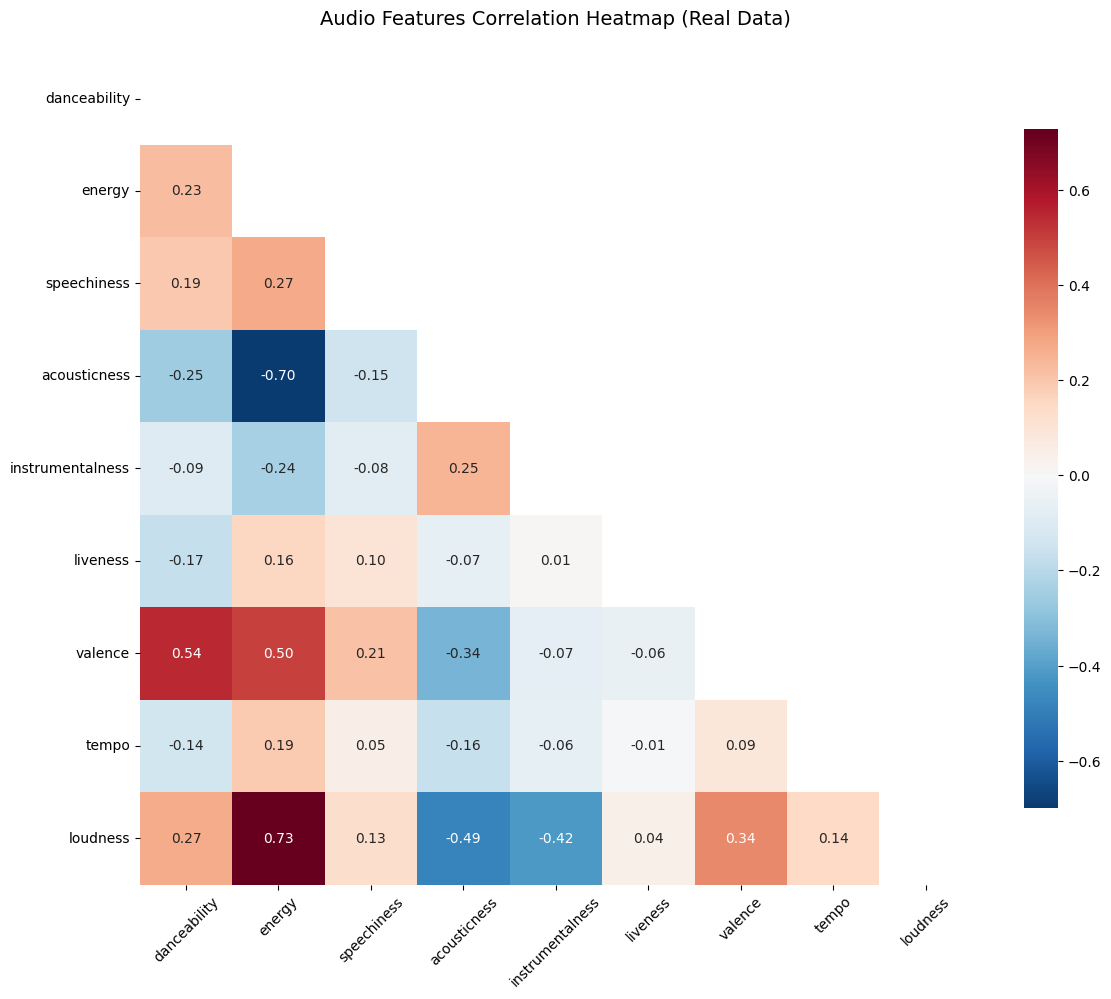

🔍 강한 상관관계 (|r| > 0.5):
  danceability ↔ valence: 0.545
  energy ↔ acousticness: -0.699
  energy ↔ loudness: 0.728


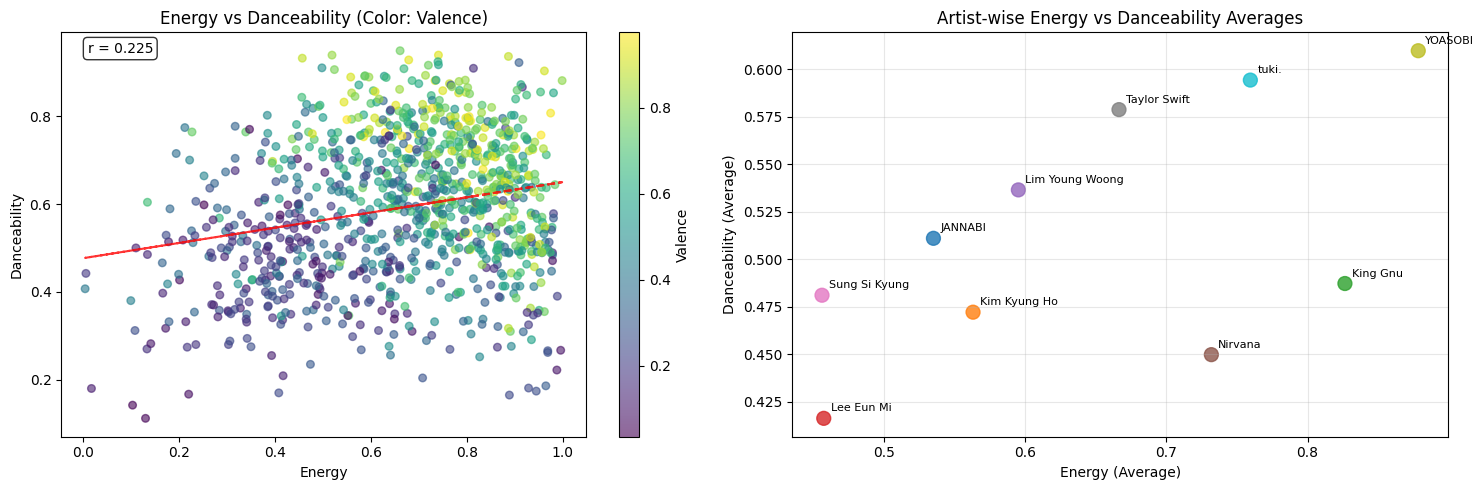

In [14]:
if len(df_complete) > 10:
    # 상관관계 계산
    correlation_matrix = df_complete[audio_features].corr()
    
    # 상관관계 히트맵
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # 상삼각 마스크
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={"shrink": .8})
    
    plt.title('Audio Features Correlation Heatmap (Real Data)', fontsize=14, pad=20)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # 강한 상관관계 찾기
    print("🔍 강한 상관관계 (|r| > 0.5):")
    strong_corr = []
    
    for i in range(len(audio_features)):
        for j in range(i+1, len(audio_features)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_corr.append((audio_features[i], audio_features[j], corr_val))
                print(f"  {audio_features[i]} ↔ {audio_features[j]}: {corr_val:.3f}")
    
    if not strong_corr:
        print("  강한 상관관계가 발견되지 않았습니다.")
    
    # 특정 관계 심층 분석: Energy vs Danceability
    if 'energy' in df_complete.columns and 'danceability' in df_complete.columns:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # 산점도
        scatter = axes[0].scatter(df_complete['energy'], df_complete['danceability'], 
                                 c=df_complete['valence'], cmap='viridis', alpha=0.6, s=30)
        axes[0].set_xlabel('Energy')
        axes[0].set_ylabel('Danceability')
        axes[0].set_title('Energy vs Danceability (Color: Valence)')
        plt.colorbar(scatter, ax=axes[0], label='Valence')
        
        # 회귀선 추가
        z = np.polyfit(df_complete['energy'], df_complete['danceability'], 1)
        p = np.poly1d(z)
        axes[0].plot(df_complete['energy'], p(df_complete['energy']), "r--", alpha=0.8)
        
        # 상관계수 표시
        r_value = df_complete['energy'].corr(df_complete['danceability'])
        axes[0].text(0.05, 0.95, f'r = {r_value:.3f}', transform=axes[0].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 아티스트별 평균값 (상위 10명)
        artist_counts = df_complete['artist'].value_counts()
        top_artists = artist_counts.head(10).index
        df_top_artists = df_complete[df_complete['artist'].isin(top_artists)]
        
        if len(df_top_artists) > 0:
            artist_means = df_top_artists.groupby('artist')[['energy', 'danceability']].mean()
            axes[1].scatter(artist_means['energy'], artist_means['danceability'], 
                           s=100, alpha=0.8, c=range(len(artist_means)), cmap='tab10')
            
            for i, (artist, row) in enumerate(artist_means.iterrows()):
                # 긴 아티스트 이름은 줄여서 표시
                display_name = artist[:15] + '...' if len(artist) > 15 else artist
                axes[1].annotate(display_name, 
                                (row['energy'], row['danceability']),
                                xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            axes[1].set_xlabel('Energy (Average)')
            axes[1].set_ylabel('Danceability (Average)')
            axes[1].set_title('Artist-wise Energy vs Danceability Averages')
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("상관관계 분석을 위한 충분한 데이터가 없습니다.")

### 9.3 이상치 탐지

이상치(outlier)는 다른 데이터와 현저히 다른 값들이다. 실제 음원 데이터에서 이상치를 찾아보자.
예를 들어 템포가 극단적으로 빠르거나 느린 곡, 에너지와 댄서빌리티가 특이한 조합을 가진 곡 등을 찾을 수 있다.

#### IQR 방법
**IQR(Interquartile Range)**은 데이터의 중간 50%가 퍼져있는 범위다.
- Q1(1사분위수): 하위 25% 지점
- Q3(3사분위수): 상위 25% 지점  
- IQR = Q3 - Q1
- 이상치 기준: Q1 - 1.5×IQR 미만 또는 Q3 + 1.5×IQR 초과
- 💡 박스플롯의 수염을 벗어나는 점들이 바로 IQR 이상치!

#### Z-score 방법
**Z-score**는 데이터가 평균에서 얼마나 떨어져 있는지를 표준편차 단위로 표현한다.
- Z-score = (값 - 평균) / 표준편차
- 이상치 기준: |Z-score| > 3 (평균에서 3 표준편차 이상 떨어진 값)
- 💡 정규분포에서 99.7%의 데이터는 ±3σ 안에 있으므로, 그 밖의 0.3%를 이상치로 본다.

두 방법의 차이:
- **IQR**: 분포 형태에 관계없이 사용 가능, 극단값에 덜 민감
- **Z-score**: 정규분포 가정, 평균과 표준편차에 민감

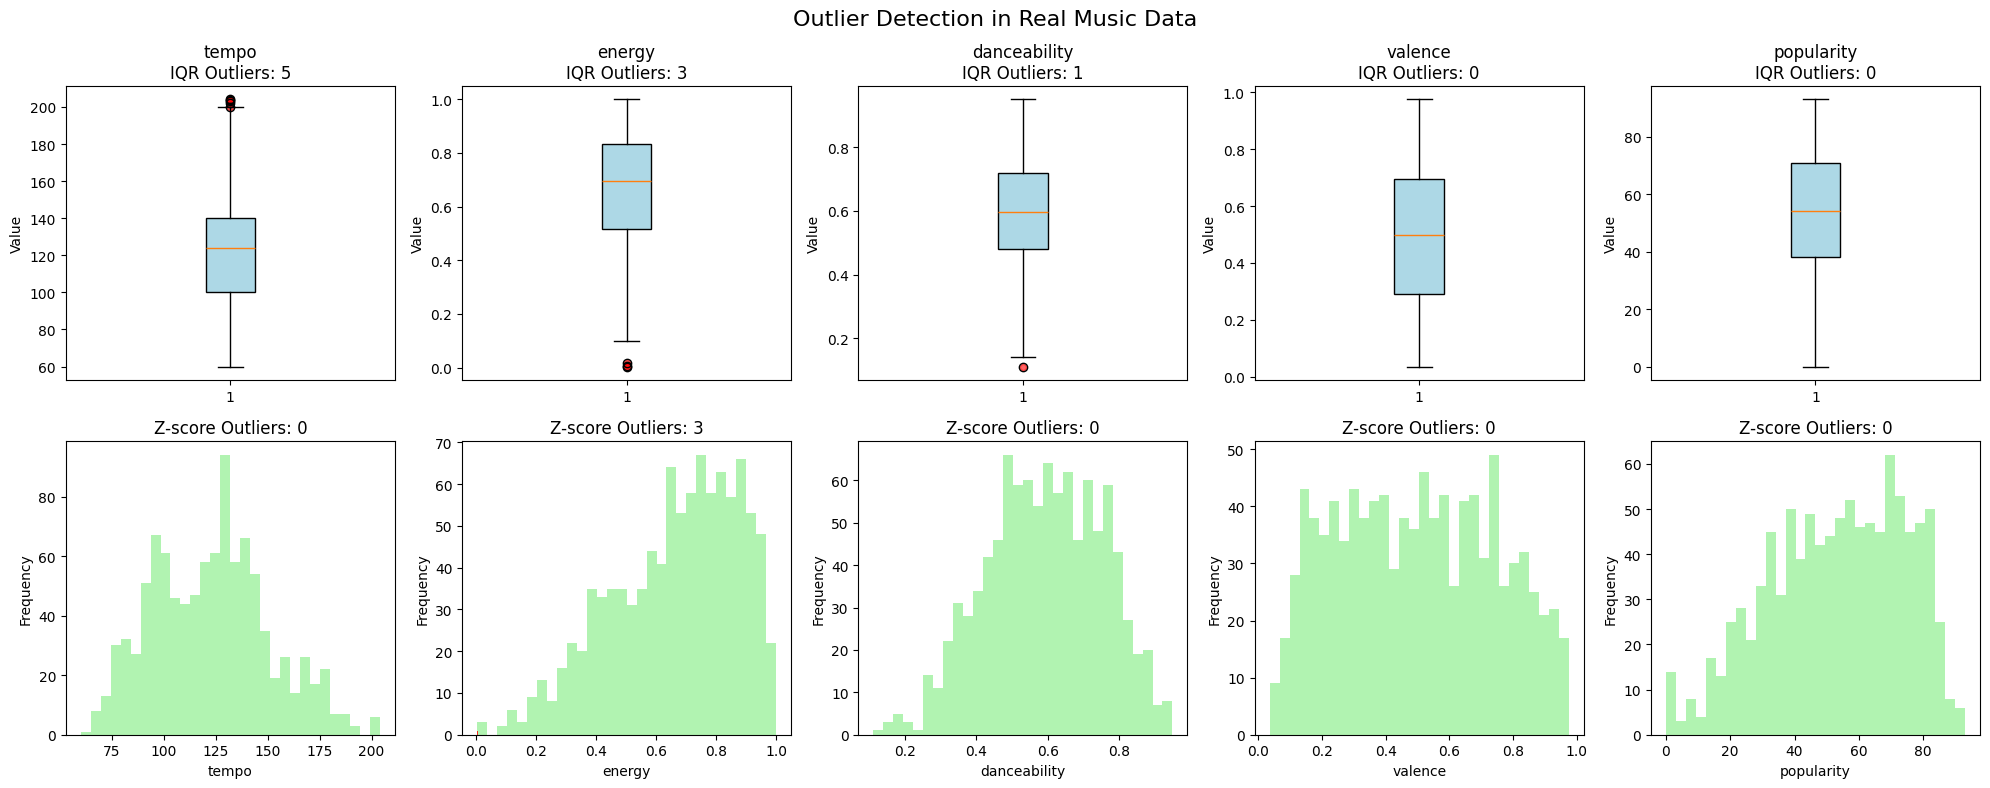

🚨 이상치 탐지 결과:
특징		IQR 방법	Z-score 방법
----------------------------------------
tempo               5개	       0개
energy              3개	       3개
danceability        1개	       0개
valence             0개	       0개
popularity          0개	       0개

🔍 다변량 이상치 탐지 결과:
  전체 데이터: 1000개
  이상치: 50개 (5.0%)
  정상치: 950개 (95.0%)

🎵 이상치로 탐지된 곡들 (상위 5개):
  - Graceful Rhapsody by Velvet Groove
    Tempo: 96.4, Energy: 0.18, Danceability: 0.51
  - さくら - 独唱 by Naotaro Moriyama
    Tempo: 72.0, Energy: 0.18, Danceability: 0.59
  - butterflies (feat. TAEHYUN & Kim Chaewon of LE SSERAFIM) by JVKE, TOMORROW X TOGETHER, LE SSERAFIM, TAEHYUN, KIM CHAEWON
    Tempo: 202.3, Energy: 0.78, Danceability: 0.50
  - 아 목동아 by 오르골
    Tempo: 93.5, Energy: 0.28, Danceability: 0.57
  - Unread Message by Lim Young Woong
    Tempo: 199.9, Energy: 0.58, Danceability: 0.64


In [15]:
if len(df_complete) > 10:
    def detect_outliers_iqr(data, column):
        """IQR 방법으로 이상치 탐지"""
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        return outliers, lower_bound, upper_bound
    
    def detect_outliers_zscore(data, column, threshold=3):
        """Z-score 방법으로 이상치 탐지"""
        z_scores = np.abs(stats.zscore(data[column]))
        outliers = data[z_scores > threshold]
        return outliers
    
    # 주요 특징들의 이상치 탐지
    outlier_features = ['tempo', 'energy', 'danceability', 'valence', 'popularity']
    
    fig, axes = plt.subplots(2, len(outlier_features), figsize=(20, 8))
    fig.suptitle('Outlier Detection in Real Music Data', fontsize=16)
    
    outlier_summary = {}
    
    for i, feature in enumerate(outlier_features):
        if feature in df_complete.columns:
            # IQR 방법
            iqr_outliers, lower, upper = detect_outliers_iqr(df_complete, feature)
            
            # Z-score 방법
            zscore_outliers = detect_outliers_zscore(df_complete, feature)
            
            outlier_summary[feature] = {
                'IQR': len(iqr_outliers),
                'Z-score': len(zscore_outliers)
            }
            
            # 박스플롯 (IQR 이상치 표시)
            bp1 = axes[0, i].boxplot(df_complete[feature], patch_artist=True)
            bp1['boxes'][0].set_facecolor('lightblue')
            axes[0, i].scatter(np.ones(len(iqr_outliers)), iqr_outliers[feature], 
                              color='red', alpha=0.6, s=20)
            axes[0, i].set_title(f'{feature}\nIQR Outliers: {len(iqr_outliers)}')
            axes[0, i].set_ylabel('Value')
            
            # 히스토그램 (Z-score 이상치 표시)
            axes[1, i].hist(df_complete[feature], bins=30, alpha=0.7, color='lightgreen')
            if len(zscore_outliers) > 0:
                axes[1, i].hist(zscore_outliers[feature], bins=30, alpha=0.8, color='red')
            axes[1, i].set_title(f'Z-score Outliers: {len(zscore_outliers)}')
            axes[1, i].set_xlabel(feature)
            axes[1, i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # 이상치 요약
    print("🚨 이상치 탐지 결과:")
    print("특징\t\tIQR 방법\tZ-score 방법")
    print("-" * 40)
    for feature in outlier_features:
        if feature in outlier_summary:
            iqr_count = outlier_summary[feature]['IQR']
            zscore_count = outlier_summary[feature]['Z-score']
            print(f"{feature:<15}{iqr_count:>6}개\t{zscore_count:>8}개")
    
    # 다변량 이상치 탐지 (Isolation Forest)
    from sklearn.ensemble import IsolationForest
    from sklearn.preprocessing import StandardScaler
    
    # 다변량 이상치 탐지를 위한 특징 선택
    multi_features = ['tempo', 'energy', 'danceability', 'valence', 'acousticness']
    available_features = [f for f in multi_features if f in df_complete.columns]
    
    if len(available_features) >= 3:
        X = df_complete[available_features].values
        
        # 데이터 정규화
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Isolation Forest로 이상치 탐지
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        outlier_labels = iso_forest.fit_predict(X_scaled)
        
        # 이상치와 정상치 분리
        df_with_outliers = df_complete.copy()
        df_with_outliers['is_outlier'] = outlier_labels == -1
        
        outliers_multi = df_with_outliers[df_with_outliers['is_outlier']]
        normal_data = df_with_outliers[~df_with_outliers['is_outlier']]
        
        print(f"\n🔍 다변량 이상치 탐지 결과:")
        print(f"  전체 데이터: {len(df_complete)}개")
        print(f"  이상치: {len(outliers_multi)}개 ({len(outliers_multi)/len(df_complete)*100:.1f}%)")
        print(f"  정상치: {len(normal_data)}개 ({len(normal_data)/len(df_complete)*100:.1f}%)")
        
        if len(outliers_multi) > 0:
            print(f"\n🎵 이상치로 탐지된 곡들 (상위 5개):")
            for idx, row in outliers_multi.head(5).iterrows():
                print(f"  - {row['name']} by {row['artist']}")
                if 'tempo' in row:
                    print(f"    Tempo: {row['tempo']:.1f}, Energy: {row['energy']:.2f}, Danceability: {row['danceability']:.2f}")
else:
    print("이상치 탐지를 위한 충분한 데이터가 없습니다.")

## 10. 실제 데이터로 PCA 분석하기

### 10.1 PCA의 필요성

우리가 수집한 음원 데이터에는 8개의 오디오 특성이 있다:
- danceability, energy, speechiness, acousticness, instrumentalness, liveness, valence, tempo

이렇게 많은 특성을 한 번에 시각화하고 분석하는 것은 어렵다.
PCA(주성분 분석)를 사용하면 이 8차원 데이터를 2차원으로 축소하여 전체적인 패턴을 파악할 수 있다.

In [24]:
# PCA를 위한 추가 라이브러리 import
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 오디오 특성이 완전한 트랙만 필터링 (PCA용)
if not df_tracks.empty:
    pca_features = ['danceability', 'energy', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 'tempo']
    
    # NaN 값이 없는 트랙만 선택
    df_pca = df_tracks.dropna(subset=pca_features).copy()
    
    print(f"PCA 분석을 위한 데이터:")
    print(f"  전체 트랙 수: {len(df_tracks)}")
    print(f"  완전한 오디오 특성을 가진 트랙 수: {len(df_pca)}")
    
    if len(df_pca) > 0:
        print(f"\n샘플 데이터:")
        display(df_pca[['name', 'artist'] + pca_features].head())
    else:
        print("완전한 오디오 특성을 가진 트랙이 없습니다.")
else:
    print("데이터가 없습니다.")
    df_pca = pd.DataFrame()

PCA 분석을 위한 데이터:
  전체 트랙 수: 1000
  완전한 오디오 특성을 가진 트랙 수: 1000

샘플 데이터:


,name,artist,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,"WITCH (Feat. Jay Park, So!YoON!) (Prod. by Slom)","Lee Young Ji, Jay Park, So!YoON!",0.909,0.814,0.1750,0.09790,0.000143,0.0875,0.158,109.999
1,Trouble,"Christopher, Lee Young Ji",0.652,0.752,0.3340,0.10200,0.000002,0.0979,0.887,96.215
2,My cat,Lee Young Ji,0.808,0.685,0.0615,0.35500,0.000000,0.2200,0.441,94.015
3,Fraktsiya,"MARK, Lee Young Ji",0.765,0.726,0.1890,0.00262,0.000000,0.0718,0.568,152.049
4,ADHD (feat. Jambino),"Lee Young Ji, Jambino",0.889,0.558,0.0550,0.18200,0.000000,0.0437,0.914,92.006


### 10.2 데이터 전처리 및 정규화

정규화 전 데이터 통계:
평균: [5.91000e-01 6.63000e-01 8.50000e-02 2.81000e-01 2.90000e-02 1.90000e-01
 4.95000e-01 1.22802e+02]
표준편차: [ 0.161  0.209  0.087  0.289  0.14   0.158  0.245 28.16 ]

정규화 후 데이터 통계:
평균: [-0.  0.  0. -0. -0.  0. -0.  0.]
표준편차: [1. 1. 1. 1. 1. 1. 1. 1.]


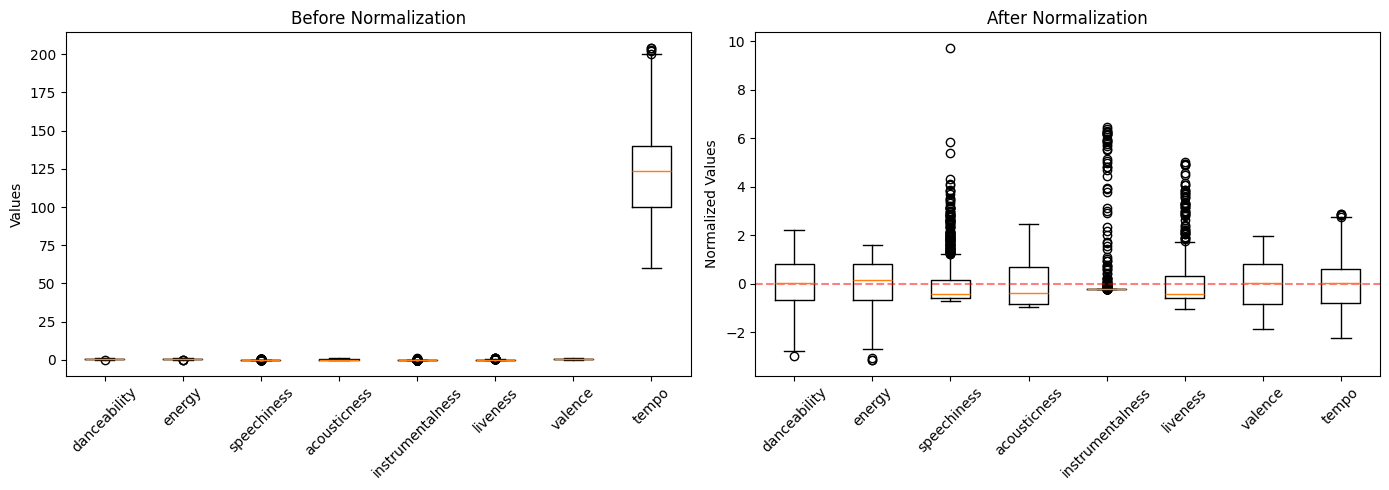

정규화 완료: 이제 모든 특성이 같은 스케일을 가집니다


In [25]:
if len(df_pca) > 10:  # 충분한 데이터가 있을 때만 진행
    # 오디오 특성 데이터 추출
    X = df_pca[pca_features].values
    
    print("정규화 전 데이터 통계:")
    print(f"평균: {X.mean(axis=0).round(3)}")
    print(f"표준편차: {X.std(axis=0).round(3)}")
    
    # StandardScaler로 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("\n정규화 후 데이터 통계:")
    print(f"평균: {X_scaled.mean(axis=0).round(3)}")
    print(f"표준편차: {X_scaled.std(axis=0).round(3)}")
    
    # 정규화 전후 비교 시각화
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.boxplot(X, labels=pca_features)
    plt.title('Before Normalization')
    plt.xticks(rotation=45)
    plt.ylabel('Values')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(X_scaled, labels=pca_features)
    plt.title('After Normalization')
    plt.xticks(rotation=45)
    plt.ylabel('Normalized Values')
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    print("정규화 완료: 이제 모든 특성이 같은 스케일을 가집니다")
else:
    print("PCA 분석을 위한 충분한 데이터가 없습니다.")

### 10.3 PCA 적용 및 결과 해석

PCA 결과:
원본 데이터 차원: 8차원
축소된 데이터 차원: 2차원

각 주성분이 설명하는 분산:
PC1: 31.6%
PC2: 16.5%
총 설명된 분산: 48.1%

주성분의 구성 요소 (로딩):
                    PC1    PC2
danceability      0.357  0.576
energy            0.530 -0.235
speechiness       0.271 -0.028
acousticness     -0.485  0.207
instrumentalness -0.225  0.182
liveness          0.033 -0.508
valence           0.463  0.306
tempo             0.132 -0.430


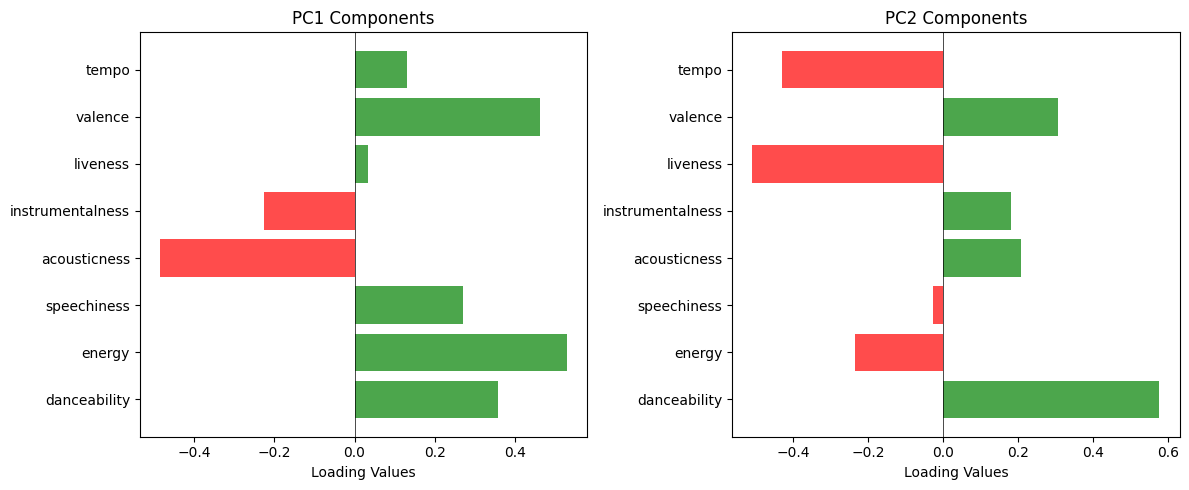


주성분 해석:
PC1의 주요 특성:
  - energy: 높을수록 PC1 값이 증가
  - acousticness: 낮을수록 PC1 값이 증가
  - valence: 높을수록 PC1 값이 증가

PC2의 주요 특성:
  - danceability: 높을수록 PC2 값이 증가
  - liveness: 낮을수록 PC2 값이 증가
  - tempo: 낮을수록 PC2 값이 증가


In [26]:
if len(df_pca) > 10:
    # PCA 실행 (2차원으로 축소)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    print("PCA 결과:")
    print(f"원본 데이터 차원: {X_scaled.shape[1]}차원")
    print(f"축소된 데이터 차원: {X_pca.shape[1]}차원")
    
    # 설명된 분산 비율
    explained_variance = pca.explained_variance_ratio_
    print(f"\n각 주성분이 설명하는 분산:")
    print(f"PC1: {explained_variance[0]*100:.1f}%")
    print(f"PC2: {explained_variance[1]*100:.1f}%")
    print(f"총 설명된 분산: {sum(explained_variance)*100:.1f}%")
    
    # 주성분의 구성 요소 (로딩)
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=['PC1', 'PC2'],
        index=pca_features
    )
    
    print("\n주성분의 구성 요소 (로딩):")
    print(loadings.round(3))
    
    # 로딩 시각화
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    colors1 = ['green' if x > 0 else 'red' for x in loadings['PC1']]
    plt.barh(loadings.index, loadings['PC1'], color=colors1, alpha=0.7)
    plt.title('PC1 Components')
    plt.xlabel('Loading Values')
    plt.axvline(x=0, color='black', linewidth=0.5)
    
    plt.subplot(1, 2, 2)
    colors2 = ['green' if x > 0 else 'red' for x in loadings['PC2']]
    plt.barh(loadings.index, loadings['PC2'], color=colors2, alpha=0.7)
    plt.title('PC2 Components')
    plt.xlabel('Loading Values')
    plt.axvline(x=0, color='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # 해석
    print("\n주성분 해석:")
    top_pc1 = loadings['PC1'].abs().nlargest(3)
    print("PC1의 주요 특성:")
    for feature in top_pc1.index:
        value = loadings.loc[feature, 'PC1']
        direction = "높을수록" if value > 0 else "낮을수록"
        print(f"  - {feature}: {direction} PC1 값이 증가")
    
    top_pc2 = loadings['PC2'].abs().nlargest(3)
    print("\nPC2의 주요 특성:")
    for feature in top_pc2.index:
        value = loadings.loc[feature, 'PC2']
        direction = "높을수록" if value > 0 else "낮을수록"
        print(f"  - {feature}: {direction} PC2 값이 증가")

### 10.4 PCA 공간에서 음악 시각화

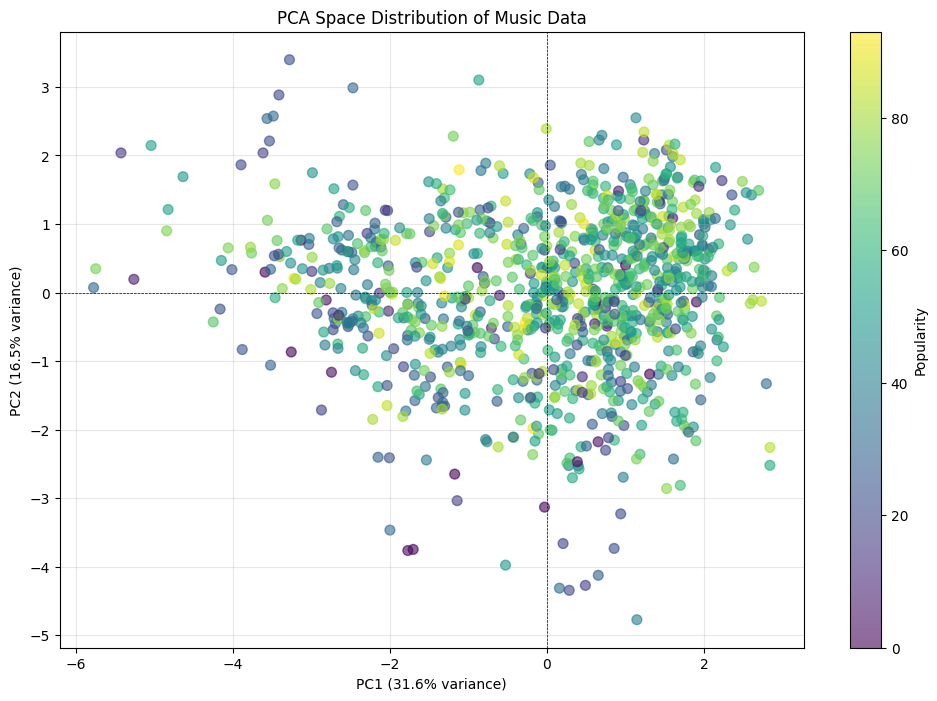

PCA 공간에서의 특이점들:

PC1 최고점: Empire State Of Mind - JAY-Z, Alicia Keys
  위치: PC1=2.84, PC2=-2.26

PC1 최저점: Paradis: Sicilienne 파라디스 시실리안느 - 김준영
  위치: PC1=-5.77, PC2=0.07

PC2 최고점: 똑같아요 - 오르골 Version - 오르골 엔젤
  위치: PC1=-3.28, PC2=3.40

최고 인기곡: DAISIES - Justin Bieber
  위치: PC1=-1.12, PC2=1.79
  인기도: 93


In [27]:
if len(df_pca) > 10:
    # PCA 결과를 데이터프레임으로 정리
    pca_df = df_pca.copy()
    pca_df['PC1'] = X_pca[:, 0]
    pca_df['PC2'] = X_pca[:, 1]
    
    # 전체 음악 분포 시각화
    plt.figure(figsize=(12, 8))
    
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                         alpha=0.6, s=50, c=pca_df['popularity'], 
                         cmap='viridis')
    
    plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)')
    plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)')
    plt.title('PCA Space Distribution of Music Data')
    plt.colorbar(scatter, label='Popularity')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    
    plt.show()
    
    # 인기 곡들 확인
    print("PCA 공간에서의 특이점들:")
    
    # PC1이 가장 높은 곡
    max_pc1 = pca_df.loc[pca_df['PC1'].idxmax()]
    print(f"\nPC1 최고점: {max_pc1['name']} - {max_pc1['artist']}")
    print(f"  위치: PC1={max_pc1['PC1']:.2f}, PC2={max_pc1['PC2']:.2f}")
    
    # PC1이 가장 낮은 곡
    min_pc1 = pca_df.loc[pca_df['PC1'].idxmin()]
    print(f"\nPC1 최저점: {min_pc1['name']} - {min_pc1['artist']}")
    print(f"  위치: PC1={min_pc1['PC1']:.2f}, PC2={min_pc1['PC2']:.2f}")
    
    # PC2가 가장 높은 곡
    max_pc2 = pca_df.loc[pca_df['PC2'].idxmax()]
    print(f"\nPC2 최고점: {max_pc2['name']} - {max_pc2['artist']}")
    print(f"  위치: PC1={max_pc2['PC1']:.2f}, PC2={max_pc2['PC2']:.2f}")
    
    # 가장 인기있는 곡
    most_popular = pca_df.loc[pca_df['popularity'].idxmax()]
    print(f"\n최고 인기곡: {most_popular['name']} - {most_popular['artist']}")
    print(f"  위치: PC1={most_popular['PC1']:.2f}, PC2={most_popular['PC2']:.2f}")
    print(f"  인기도: {most_popular['popularity']}")

### 10.5 PCA를 활용한 음악 유사도 분석

🎵 '1v520W6rEa0nB2vvqAxnU3' ID를 가진 곡과 유사한 트랙들:

기준 곡: WITCH (Feat. Jay Park, So!YoON!) (Prod. by Slom) - Lee Young Ji, Jay Park, So!YoON!
Spotify ID: 1v520W6rEa0nB2vvqAxnU3
위치: PC1=1.01, PC2=0.87
인기도: 44

유사한 곡들:
  0.054 - GIRLS by CHANMINA
    Spotify ID: 7DQYAPZsNdmwh2Si3oEutP (인기도: 49)
  0.079 - New Face by PSY
    Spotify ID: 25YgkxnU4UzEG4ORni69Rw (인기도: 55)
  0.088 - Good Graces by Sabrina Carpenter
    Spotify ID: 102YUQbYmwdBXS7jwamI90 (인기도: 79)
  0.098 - OH MAN by Justin Bieber
    Spotify ID: 6PlDfaiu0l777DqPolHkDQ (인기도: 69)
  0.125 - Smooth Criminal - 2012 Remaster by Michael Jackson
    Spotify ID: 2bCQHF9gdG5BNDVuEIEnNk (인기도: 73)


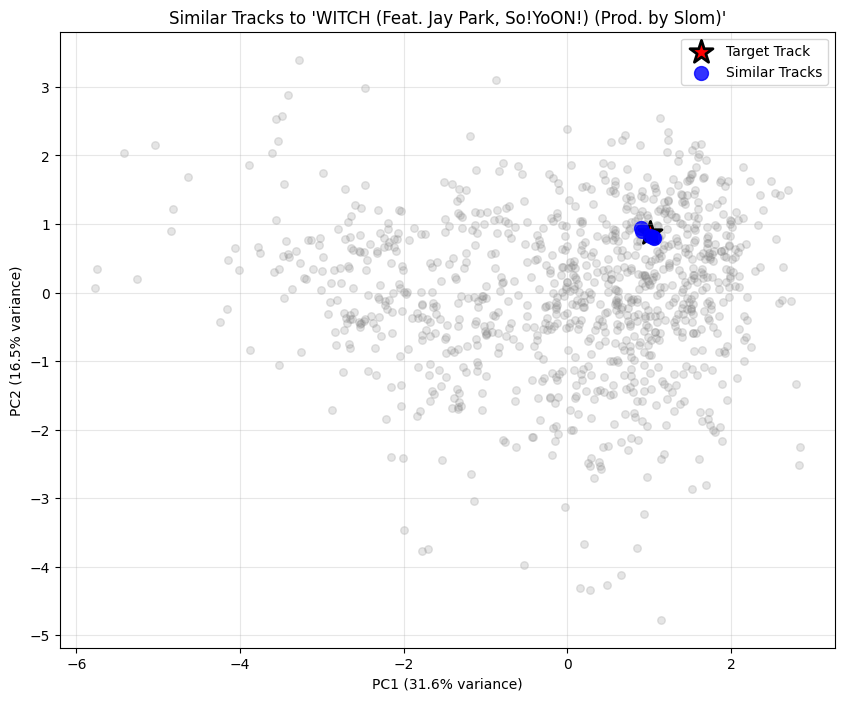


💡 사용법:
find_similar_tracks_pca('your_spotify_id', pca_df, top_n=5)

💡 PCA의 활용:
- Spotify ID 기반 음악 추천 시스템
- 유사한 음악들이 가까운 위치에 모여있음
- 음악 추천 시스템의 기초 알고리즘으로 활용 가능
- 새로운 음악의 장르나 특성을 예측할 수 있음


In [31]:
if len(df_pca) > 10:
    def find_similar_tracks_pca(spotify_id: str, pca_df: pd.DataFrame, top_n: int = 5):
        """PCA 공간에서 특정 Spotify ID와 가장 유사한 트랙 찾기"""
        
        # 타겟 트랙 찾기
        target_tracks = pca_df[pca_df['spotify_id'] == spotify_id]
        
        if len(target_tracks) == 0:
            print(f"'{spotify_id}' Spotify ID를 찾을 수 없습니다.")
            return None, None
        
        target = target_tracks.iloc[0]
        target_pc1 = target['PC1']
        target_pc2 = target['PC2']
        
        # 모든 트랙과의 유클리드 거리 계산
        distances = np.sqrt((pca_df['PC1'] - target_pc1)**2 + 
                           (pca_df['PC2'] - target_pc2)**2)
        
        # 자기 자신을 제외하고 가장 가까운 트랙들
        pca_df_copy = pca_df.copy()
        pca_df_copy['distance'] = distances
        similar = pca_df_copy[pca_df_copy['spotify_id'] != spotify_id].nsmallest(top_n, 'distance')
        
        return target, similar
    
    # 예시: 데이터베이스에 있는 트랙 중 하나를 선택해서 유사한 곡 찾기
    if len(pca_df) > 5:
        # 첫 번째 트랙의 Spotify ID 사용
        sample_spotify_id = pca_df.iloc[0]['spotify_id']
        
        print(f"🎵 '{sample_spotify_id}' ID를 가진 곡과 유사한 트랙들:")
        target, similar = find_similar_tracks_pca(sample_spotify_id, pca_df, top_n=5)
        
        if target is not None:
            print(f"\n기준 곡: {target['name']} - {target['artist']}")
            print(f"Spotify ID: {target['spotify_id']}")
            print(f"위치: PC1={target['PC1']:.2f}, PC2={target['PC2']:.2f}")
            print(f"인기도: {target['popularity']}")
            
            print("\n유사한 곡들:")
            for idx, row in similar.iterrows():
                print(f"  {row['distance']:.3f} - {row['name']} by {row['artist']}")
                print(f"    Spotify ID: {row['spotify_id']} (인기도: {row['popularity']})")
            
            # 시각화
            plt.figure(figsize=(10, 8))
            
            # 모든 곡 (회색, 작게)
            plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, s=30, c='gray')
            
            # 타겟 곡 (빨간 별)
            plt.scatter(target['PC1'], target['PC2'], s=300, c='red', 
                       marker='*', edgecolor='black', linewidth=2, label='Target Track')
            
            # 유사한 곡들 (파란 원)
            plt.scatter(similar['PC1'], similar['PC2'], s=100, c='blue',
                       alpha=0.8, label='Similar Tracks')
            
            # 연결선
            for idx, row in similar.iterrows():
                plt.plot([target['PC1'], row['PC1']], 
                        [target['PC2'], row['PC2']], 
                        'b--', alpha=0.3, linewidth=1)
            
            plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)')
            plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)')
            plt.title(f"Similar Tracks to '{target['name']}'")
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.show()
        
        print("\n💡 사용법:")
        print("find_similar_tracks_pca('your_spotify_id', pca_df, top_n=5)")
        print("\n💡 PCA의 활용:")
        print("- Spotify ID 기반 음악 추천 시스템")
        print("- 유사한 음악들이 가까운 위치에 모여있음") 
        print("- 음악 추천 시스템의 기초 알고리즘으로 활용 가능")
        print("- 새로운 음악의 장르나 특성을 예측할 수 있음")